# Deep Dive 1 in GBSV - Part 2

# Imports

In [1]:
import cv2 as cv
import librosa
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd

from enum import IntEnum
from ipywidgets import interact, widgets, HBox
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim

# Filtering
Filtering is a common process on signals and images. It can be used to remove noise, to enhance features, or even extract specific features like for example edges in image data. The main difference compared to the point-wise operations before is that now not only one origin pixel is taken into considerations but also its neighbors.

#### <font color='blue'>Exercise:</font> 
How many neighbors do exists for a pixel?

## Smoothing-Filter on 1D-Signals
We first start by looking at a filter for 1D-signals.
For this we take a small extract of the sample recorded before:

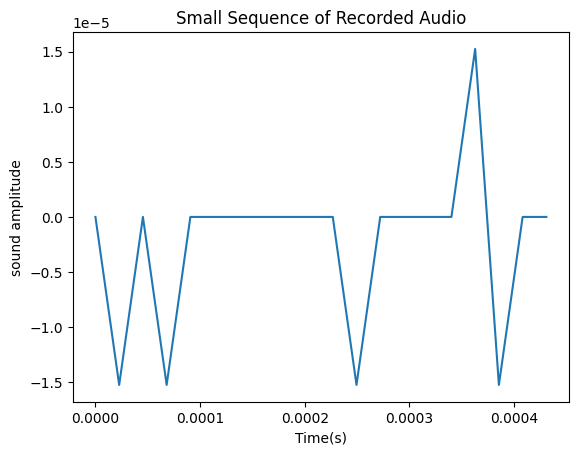

In [2]:
# Load audio from previous notebook
audio_filename = "Sounds/recording0.wav"
sampling_rate = 44100
audio, _ = librosa.load(audio_filename, sr=sampling_rate)

time = np.arange(0, len(audio))/sampling_rate
t = time[:20]
signal = audio[:20]
fig, ax = plt.subplots()
ax.plot(t, signal)
ax.set(xlabel='Time(s)', ylabel='sound amplitude')
ax.set_title("Small Sequence of Recorded Audio")
plt.show()

This signal is naturally not smooth and many jumps are recognizable. 
We want now to find a way to smoothen this signal by using a filter.

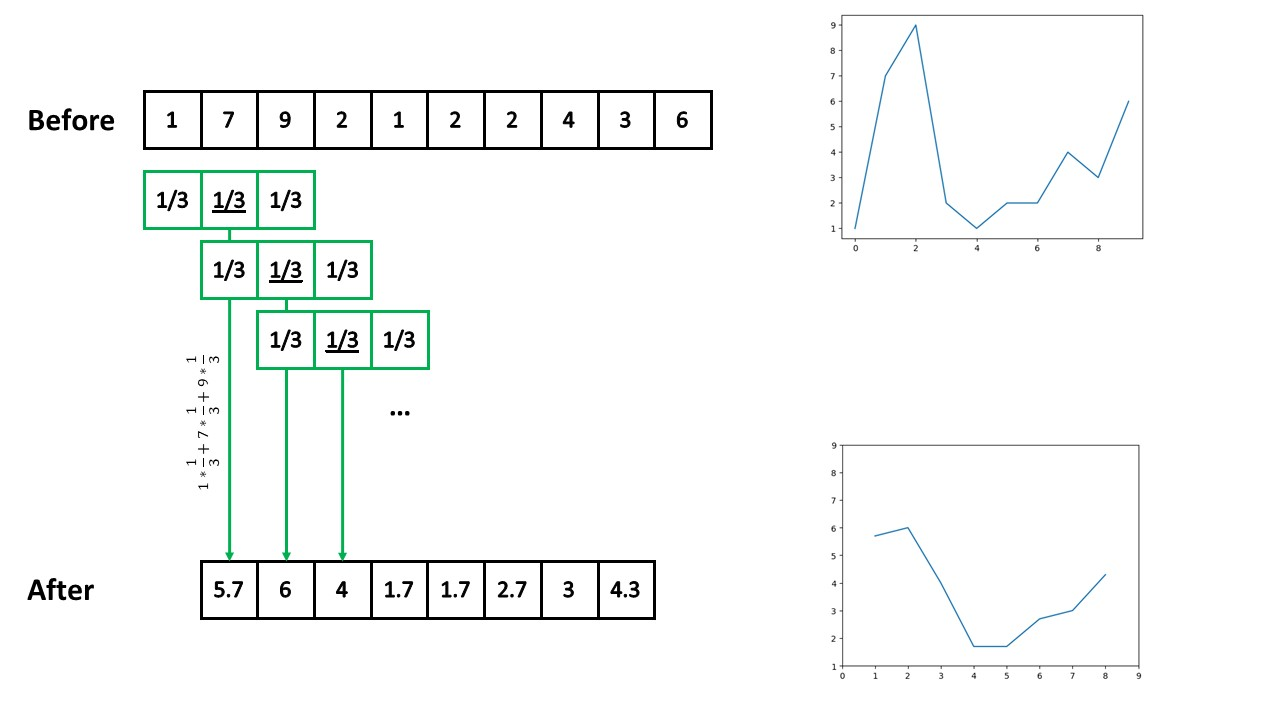

In this visualization the process of folding (also called convolution) is illustrated. This example uses a smoothing filter with a size of 3. The center of the filter is at position 2 which is marked by an underscore. 

This folding/convolution applies the filter (also called kernel) and is mathematically defined as follows:

$$(a*v)_n = \sum_{m=-\infty}^{\infty}a_mv_{n-m}$$

Based on this formula the filter must be flipped vertically before application. In our case the smoothing filter is symmetric, hence there is no need to flip it.

The resulting flipped filter is then applied to all positions in the signal where the filter fully lies inside the signal. 
For each of those positions the filter and the signal are point-wise multiplied and summed up to calculate the resulting new point in the filtered signal. For the smoothing filter this is the same as to average all corresponding values of the signal.

### Application

In [3]:
def apply_filter_1d(signal:np.array, filter:np.array, mode='valid', plot=False):
    signal_filtered = np.convolve(signal, filter, mode=mode)

    gap = len(filter)-1
    
    if plot:
        fig, ax = plt.subplots(2)
        # Plot signal
        ax[0].plot(np.arange(len(signal)), signal)
        ax[0].set(xlabel='Samples', ylabel='Sound Amplitude')
        ax[0].set_ylim(np.min(signal), np.max(signal))
        ax[0].set_xlim(0, len(signal)-1)
        ax[0].set_title("Signal")

        # Plot signal filtered
        ax[1].plot(np.arange(len(signal_filtered))+np.floor(gap/2.0), signal_filtered)
        ax[1].set(xlabel='Samples', ylabel='Sound Amplitude')
        ax[1].set_ylim(np.min(signal), np.max(signal))
        ax[1].set_xlim(0, len(signal)-1)
        ax[1].set_title("Filtered Signal")
        plt.tight_layout()
        plt.show()

    return signal_filtered

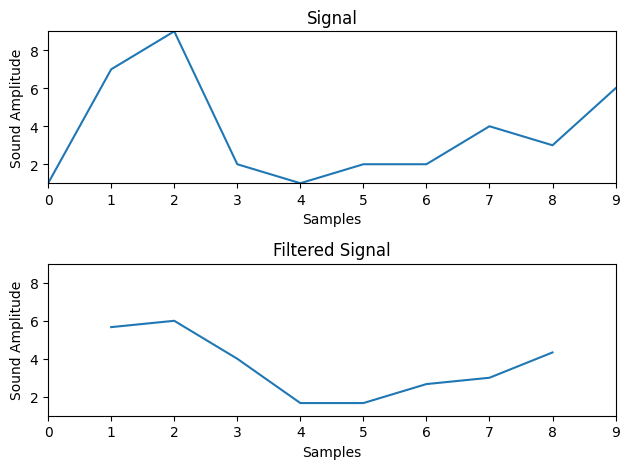

In [4]:
apply_filter_1d(signal=[1,7,9,2,1,2,2,4,3,6], filter=[1/3, 1/3, 1/3], mode='valid', plot=True);

#### <font color='blue'>Exercise:</font> 
Is there anything noticeable about the edges of the filtered signal?

Now we apply the filter function to our previously recorded audio.

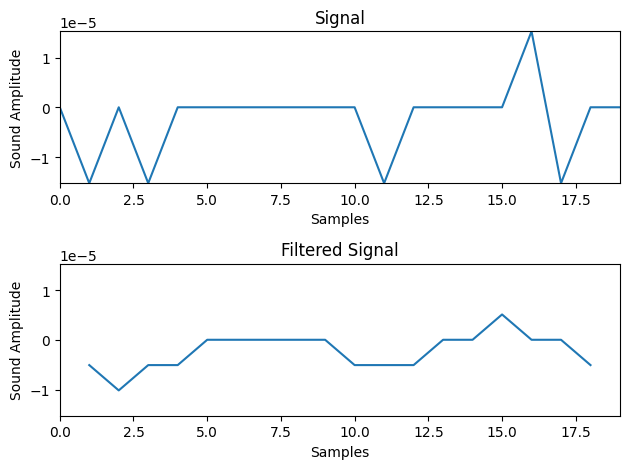

In [5]:
apply_filter_1d(signal=signal, filter=[1/3, 1/3, 1/3], mode='valid', plot=True);

#### <font color='blue'>Exercise:</font> 
What happens visually and acoustically to the recorded sound after a 1D filter is applied? Also try to apply longer filters as the ones before.

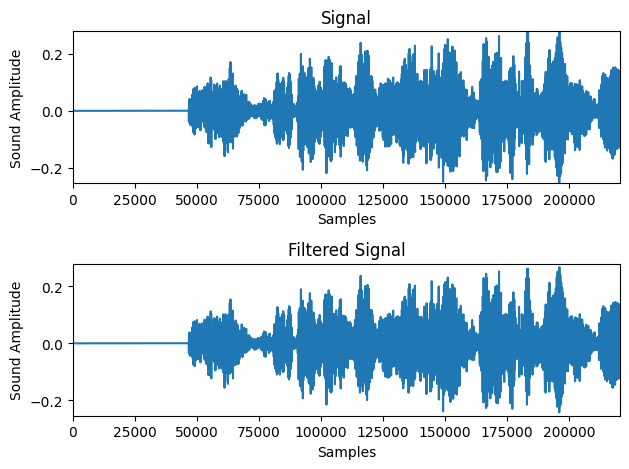

In [36]:
# Load audio with librosa
audio, _ = librosa.load("Sounds/recording0.wav", sr=sampling_rate)

#sd.play(audio, 44100)


audio_new = apply_filter_1d(signal=audio, filter=[1/10, 1/10, 1/10, 1/10, 1/10] + [1/10, 1/10, 1/10, 1/10, 1/10], mode='valid', plot=True);


sd.play(audio_new, 44100)

### END SOLUTION

#### <font color='blue'>Exercise:</font> 
Applying a filter only at positions where the filter is fully inside the signal leads to a reduction of the signal length.
Think about methods that could be applied in this setting to receive a signal after filtering that has the same output length as the input. 
Don't forget to think about larger filters than the size of 3. 
Try other modes in the function `apply_filter_1d()` than only the mode `valid` and observe the changes.

#### <font color='blue'>Exercise:</font> 
With the help of the following widget try to find a filter that shifts the signal one position to the right.

In [37]:
signal = [1,7,9,2,1,2,2,4,3,6]

# Create a function for interactive visualization
def visualize_filter(input_0: float, input_1: float, input_2: float, ):
    kernel = [input_0, input_1, input_2]

    # Apply the filter
    filtered_signal = apply_filter_1d(signal, kernel, mode='same', plot=False)
    
    fig, ax = plt.subplots()
    line, = ax.plot(np.arange(len(signal)), signal, lw=2)
    points, = ax.plot(np.arange(len(signal)), filtered_signal, lw=1)
    ax.set_xlabel('Time [s]')
    ax.legend(['Original', 'Convolved'])
    plt.show()

# Create input fields for interactive control
input_0 = widgets.FloatText(value=0.33, min=0.0, max=5.0, step=0.1)
input_1 = widgets.FloatText(value=0.33, min=0.0, max=5.0, step=0.1)
input_2 = widgets.FloatText(value=0.33, min=0.0, max=5.0, step=0.1)

float_inputs = HBox([input_0, input_1, input_2])

# Create the interactive widget
out = widgets.interactive_output(visualize_filter, {'input_0':input_0, 'input_1':input_1, 'input_2':input_2})

display(float_inputs, out)

Output()

## Filters on 2D Images
The same way as we applied the filter on 1D signals we can apply filters to 2D images. For this convolution typically 2D filters are used.

2D filters used for image convolutions are typically defined by two characteristics: size and shape:
* **Size:** The size of a filter defines how many pixels are included to calculate the convolution.
* **Shape:** The shape of the filter is dependent on the task of the filter. The shape of the filter does not have to be quadratic, it can also be circular or oval. Also having filters that are not contiguous is possible.

How much a certain pixel counts into the calculation of a new pixel is defined by the weight defined in the filter.


There exist some typical filters:
* Linear Filters
    * Smoothing Filter
        * Box Filter
        * Gaussian Filter
    * Differential Filter
        * Laplace Filter
* Non Linear Filters
    * Median Filter
    * Min-/Max Filter
 
To apply filters in this DeepDive we use the implementation of [OpenCV](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04).

In [38]:
image = cv.imread('Images/borders.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

### Linear Filter: Gauss Filter

The gauss filter is a smoothing filter and is defined as follows: $$H^{G, \sigma} = e^{-\frac{x^2+y^2}{2\sigma^2}}$$  

The standard deviation $\sigma$ in this formula defines the radius of this function. 

In [39]:
def gaussian_kernel_matrix(size, sigma, weight = 1.0):
    center = int(size*sigma)
    kernel_matrix = np.zeros((2*center+1,1))
    sigma_2 = sigma ** 2
    
    for x in range(kernel_matrix.shape[0]):
        x_ = center - x
        kernel_matrix[x] = np.exp(-0.5*(x_**2) / (sigma_2)) * np.sqrt(weight)

    kernel_matrix_ = np.dot(kernel_matrix, kernel_matrix.T)
    kernel_matrix_= np.around(kernel_matrix_, 0)
    
    return np.sum(kernel_matrix_), kernel_matrix_

In [40]:
frac, gauss_filter = gaussian_kernel_matrix(size = 2, sigma = 1.0, weight = 36)
print(gauss_filter)

[[ 1.  3.  5.  3.  1.]
 [ 3. 13. 22. 13.  3.]
 [ 5. 22. 36. 22.  5.]
 [ 3. 13. 22. 13.  3.]
 [ 1.  3.  5.  3.  1.]]


In [18]:
def apply_filter_to_image(kernel: np.array, image: np.array, amount = 1, norm: bool = True, plot: bool = False, vmin = 0, vmax = 255):
    k = kernel.copy()
    if norm:
        if np.abs(np.sum(k)) > 0: 
            k = k / float(np.sum(k))
    
    img = image
    for i in range(amount):
        img = cv.filter2D(img, ddepth=-1, kernel=k)

    if plot:
        plt.imshow(img, vmin=vmin, vmax=vmax )
        plt.title(f"Filtered Image after {amount} Filter Applications")
        plt.axis('off')
        plt.show()

    return img

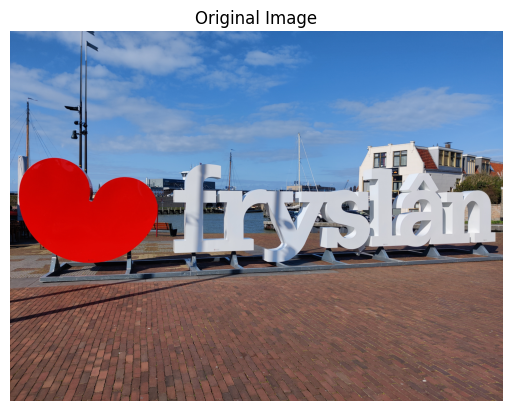

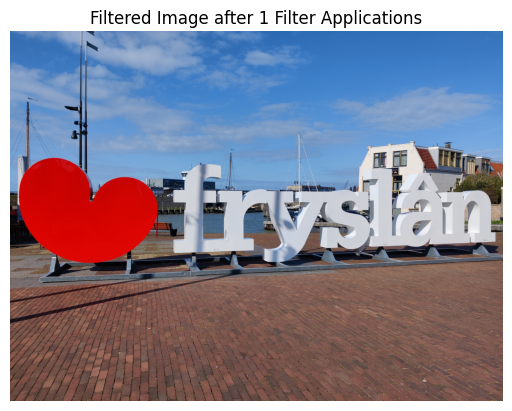

In [30]:
plt.imshow(image, vmin=0, vmax=255)
plt.title("Original Image")
plt.axis('off')
plt.show()
img_gauss_filtered = apply_filter_to_image(gauss_filter, image, amount=1, plot=True);

When only applying the Gauss filter once on a large image, hardly any changes are visible. 
We now apply a metric called ```peak_signal_noise_ratio``` ([PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)) to see, whether we really changed the image.

In [41]:
img_copy = image.copy()
img_copy[0,0,0] += 1
print(f"PSNR of original image with itself: {np.round(peak_signal_noise_ratio(image, img_copy))} dB")
print(f"PSNR of original image compared to the image with the Gauss filter: {np.round(peak_signal_noise_ratio(image, img_gauss_filtered))} dB")

PSNR of original image with itself: 124.0 dB
PSNR of original image compared to the image with the Gauss filter: 32.0 dB


Typically noisy images have a PSNR smaller than 50 dB. Everything above is great. Based on this we see that the image has definitively changed with the Gauss filter. Therefore we apply the Gauss filter several times in order to see the effect:

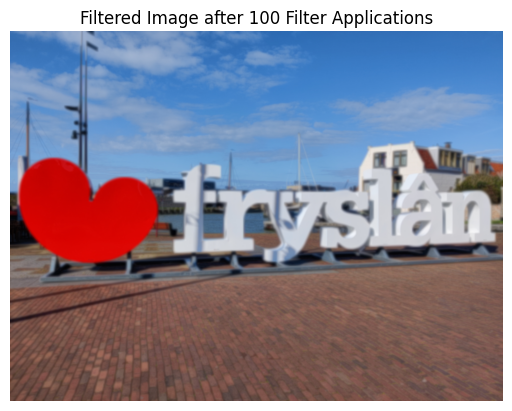

In [42]:
img_gauss_filtered_100 = apply_filter_to_image(gauss_filter, image, amount=100, plot=True);

In [43]:
print(f"PSNR of original image compared to the image with the gauss filter 100 times applied: {np.round(peak_signal_noise_ratio(image, img_gauss_filtered_100))} dB")

PSNR of original image compared to the image with the gauss filter 100 times applied: 24.0 dB


There exist also other metrics as for example the MSE and the *structural similarity index* (SSIM). 
More informations to the metrics are given in the [Lesespur]( https://spür.li/susu73s).

In [15]:
def mse(img1: np.ndarray, img2: np.ndarray) -> float:
    return np.square(np.subtract(img1, img2)).mean()

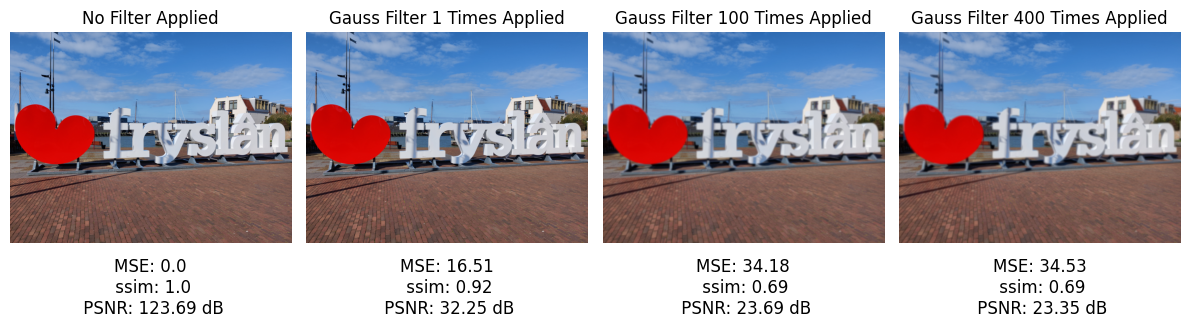

In [44]:
amount = [1, 100, 400]

fig, axs = plt.subplots(nrows=1, ncols=len(amount)+1, figsize=(12,8))

mse_original = np.round(mse(image, image), 2)
ssim_original = np.round(ssim(image, image, channel_axis=2), 2)
img_copy = image.copy()
img_copy[0,0,0] += 1
psnr_original = np.round(peak_signal_noise_ratio(image, img_copy), 2)

axs[0].imshow(image)
axs[0].set_title("No Filter Applied")
axs[0].text(x=image.shape[1]//2, y=image.shape[0]+1000, s=f"MSE: {mse_original}\n ssim: {ssim_original}\n PSNR: {psnr_original} dB", size=12, horizontalalignment='center')
axs[0].axis('off')

for idx, a in enumerate(amount):
    img_res = apply_filter_to_image(gauss_filter, image, amount=a);
    mse_gauss= np.round(mse(image, img_res), 2)
    ssim_gauss = np.round(ssim(image, img_res, channel_axis=2), 2)
    psnr_gauss = np.round(peak_signal_noise_ratio(image, img_res), 2)
    axs[idx+1].imshow(img_res)
    axs[idx+1].set_title(f"Gauss Filter {a} Times Applied")
    axs[idx+1].text(x=image.shape[1]//2, y=image.shape[0]+1000, s=f"MSE: {mse_gauss}\n ssim: {ssim_gauss}\n PSNR: {psnr_gauss} dB", size=12, horizontalalignment='center')
    axs[idx+1].axis('off')

plt.tight_layout()
plt.show()

### Other Filters
In the following widget interactive 3x3 filters can be applied on the image:

In [46]:
# Create a function for interactive visualization
def visualize_filter(input_0_0: float, input_1_0: float, input_2_0: float, 
                     input_0_1: float, input_1_1: float, input_2_1: float, 
                     input_0_2: float, input_1_2: float, input_2_2: float, 
                     amount: int=1, norm:bool = True):
    custom_filter = np.array([
            [input_0_0, input_1_0, input_2_0],
            [input_0_1, input_1_1, input_2_1],
            [input_0_2, input_1_2, input_2_2]
        ])
    
    # Apply the filter
    filtered_image = apply_filter_to_image(custom_filter, image, amount=amount, norm=norm, plot=True)

# Create input fields for interactive control
input_0_0 = widgets.FloatText(value=0.33, min=-5.0, max=5.0, step=0.1)
input_1_0 = widgets.FloatText(value=0.33, min=-5.0, max=5.0, step=0.1)
input_2_0 = widgets.FloatText(value=0.33, min=-5.0, max=5.0, step=0.1)
input_0_1 = widgets.FloatText(value=0.33, min=-5.0, max=5.0, step=0.1)
input_1_1 = widgets.FloatText(value=0.33, min=-5.0, max=5.0, step=0.1)
input_2_1 = widgets.FloatText(value=0.33, min=-5.0, max=5.0, step=0.1)
input_0_2 = widgets.FloatText(value=0.33, min=-5.0, max=5.0, step=0.1)
input_1_2 = widgets.FloatText(value=0.33, min=-5.0, max=5.0, step=0.1)
input_2_2 = widgets.FloatText(value=0.33, min=-5.0, max=5.0, step=0.1)

float_inputs_1 = HBox([input_0_0, input_1_0, input_2_0])
float_inputs_2 = HBox([input_0_1, input_1_1, input_2_1])
float_inputs_3 = HBox([input_0_2, input_1_2, input_2_2])
norm = widgets.Checkbox(value=False, description='Normalize Kernel')


# Create the interactive widget
out = widgets.interactive_output(visualize_filter, {'input_0_0':input_0_0, 'input_1_0':input_1_0, 'input_2_0':input_2_0,
                                                    'input_0_1':input_0_1, 'input_1_1':input_1_1, 'input_2_1':input_2_1,
                                                    'input_0_2':input_0_2, 'input_1_2':input_1_2, 'input_2_2':input_2_2, 
                                                    'norm':norm})

display(float_inputs_1, float_inputs_2, float_inputs_3, norm, out )


Checkbox(value=False, description='Normalize Kernel')

Output()

#### <font color='blue'>Exercise:</font>
Design your own linear filter and apply it to your image. You can turn on and off the normalization of the kernel with the checkbox.

#### <font color='blue'>Exercise:</font>
Try to find filters that do the following:
* increase brightness
* decrease brightness
* shift the image 500px to the left
* blur the image along vertical rows
* shift the image diagonal

### Edges and Derivative Filters

Edges and contours of objects are essential for the recognition of an object. The human visual system manages this task easily. But how are edges and contours represented in an image and how can they be localized?


If we look at the areas of an image where there is an edge of an object, we can see that the intensity in these areas changes in one direction. The more the intensity changes, the stronger the indication of an edge. This change in intensity can be measured by the first derivative.


For images with kernels we would need to have a discrete function $f(u)$ to calculate the derivative. Unfortunately no such function exists and a method to approximate the derivative is needed. In the following image an approximation approach is given. The rise of the tangent in point $u$ can be estimated by its neighbouring points $f(u-1)$ and $f(u+1)$. This is not the exact derivative value but is enough in most cases. 
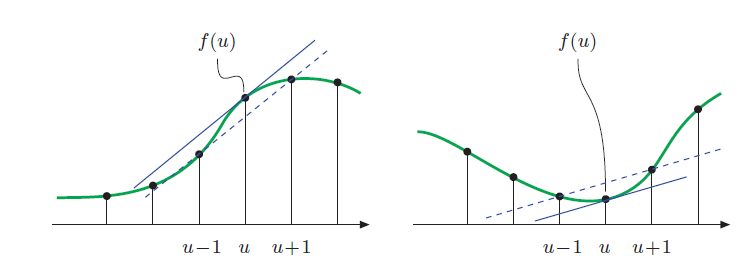

[Source](https://spaces.technik.fhnw.ch/lernmaterialien/website/digitale-bildverarbeitung-eine-algorithmische-einfuehrung-mit-java-bb15)


#### <font color='blue'>Exercise:</font>
* Based on the information above: Can you find a derivative kernel that extracts the borders of an image? (You can use the sample image "borders.jpg" or use your own image.)
* What is the shape of such a kernel?
* Does there exist multiple different kernels?
* Are all edges and contoures extracted with all different kernels?

#### Common Gradient Filter (Gradientenfilter)
Gradient filters implement first-order derivative filters. There exist two common gradient filters called **[Prewitt](https://books.google.ch/books?hl=de&lr=&id=vp-w_pC9JBAC&oi=fnd&pg=PA75&dq=Prewitt,+J.:+Object+Enhancement+and+Extraction.+In:+Lipkin,+B.+und+A.+Rosenfeld+(Hrsg.):+Picture+Processing+and+Psychopictorics,+S.+415%E2%80%93+431.+Academic+Press,+1970.&ots=sAJaZqpyLa&sig=O6_BG9PHYAliNc3q8LC_5U79bUQ&redir_esc=y#v=onepage&q&f=false)** and **[Sobel](https://www.sciencedirect.com/science/article/abs/pii/0146664X7590012X)**.

**Prewitt**
The Prewitt filter looks like the following 
$
  \begin{bmatrix}
    -1 & 0 & 1\\
    -1 & 0 & 1\\
    -1 & 0 & 1\\
  \end{bmatrix}
$
and
$
  \begin{bmatrix}
    -1 & -1 & -1\\
    0 & 0 & 0\\
    1 & 1 & 1\\
  \end{bmatrix}
$.

These filters are the extended version of the previous derivative  filters to $3\times3$ kernels.
With these filters the calculation will be averaged between three rows rspw. columns.
Better visible is this by separating the filter like this:
$
  \begin{bmatrix}
    -1 & 0 & 1\\
    -1 & 0 & 1\\
    -1 & 0 & 1\\
  \end{bmatrix}
  =
  \begin{bmatrix}
    1\\
    1\\
    1\\
  \end{bmatrix}
  *
  \begin{bmatrix}
    -1 & 0 & 1\\
  \end{bmatrix}
$. 
This form means that first a smoothing filter ($\begin{bmatrix}
    1\\
    1\\
    1\\
  \end{bmatrix}$) is applied vertically and then the calculation of the gradient follows. This form can be applied in reverse order due to commutativity of filters.


**Sobel**
The Sobel filter is similar as the Prewitt filter and looks like this:
$
  \begin{bmatrix}
    -1 & 0 & 1\\
    -2 & 0 & 2\\
    -1 & 0 & 1\\
  \end{bmatrix}
$
 and
$
  \begin{bmatrix}
    -1 & -2 & -1\\
    0 & 0 & 0\\
    1 & 2 & 1\\
  \end{bmatrix}
$.

#### <font color='blue'>Exercise:</font>
* What is the difference between the Prewitt and the Sobel filter?


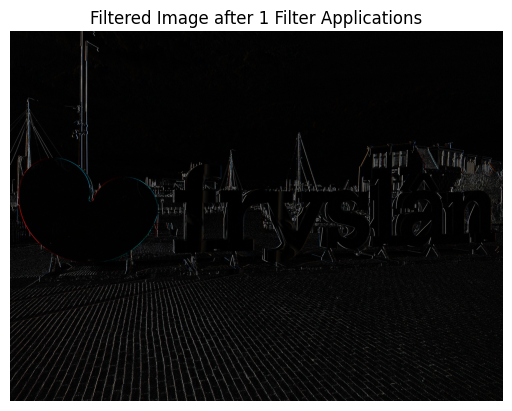

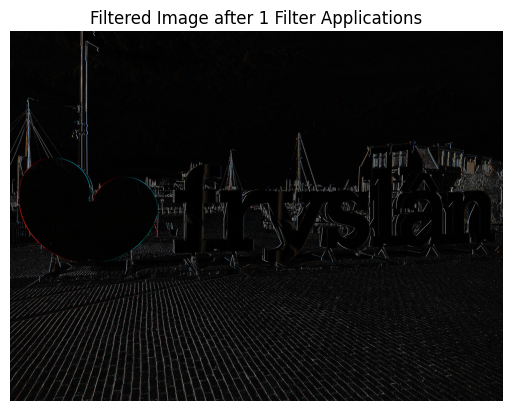

In [47]:
# Prewitt
custom_filter = np.array(
    [
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1]
    ]
)
_ = apply_filter_to_image(custom_filter, image, amount=1, plot=True)

# Sobel
custom_filter = np.array(
    [
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]
)

_ = apply_filter_to_image(custom_filter, image, amount=1, plot=True)

## Laplace Filter
The Laplace filter is as well a filter to extract the edges of an image. Compared to the Prewitt and Sobel kernel which were based on the first deviation the Laplace filter is the sum of the two second partial deviations in x- and y-direction:
$
  \begin{bmatrix}
    0 & 1 & 0\\
    1 & -4 & 1\\
    0 & 1 & 0\\
  \end{bmatrix}
  =
  \begin{bmatrix}
    1 & -2 & 1\\
  \end{bmatrix}
  +
  \begin{bmatrix}
    1\\
    -2\\
    1\\
  \end{bmatrix}
$.

A commonly used variant of the Laplace filters is the following filter:
$
  \begin{bmatrix}
    1 & 1 & 1\\
    1 & -8 & 1\\
    1 & 1 & 1\\
  \end{bmatrix}
$

#### <font color='blue'>Exercise:</font>
What is the differences between the first mentionned Laplace filter and the commonly used one?


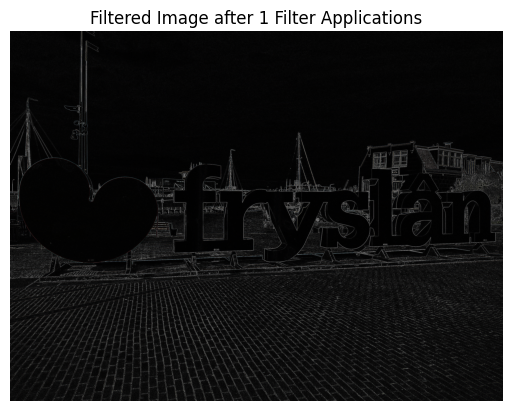

In [48]:
# Laplace Filter where the sum of the coefficients is zero.
custom_filter = np.array(
    [
        [-1, -1, -1],
        [-1, 8, -1],
        [-1, -1, -1]
    ]
)
_ = apply_filter_to_image(custom_filter, image, amount=1, plot=True)

### Non Linear Filter: Median Filter

Non-linear filters are a type of image processing filter that do not operate based on linear principles. This means that their behavior cannot be described using a simple linear equation. Unlike linear filters, which use a fixed kernel to modify an image, non-linear filters employ more complex calculations that don't rely on a straightforward kernel approach.

Examples of non linear filters are:
* median filter
* minimum filter
* maximum filter

In the subsequent discussion, we will use the median filter as an example. This filter examines a specified region in an image (similar to how a kernel would in other filters) and determines the median value of the pixels within that region. This median value then replaces the central pixel's value.after filtering

Non linear filters can for example be used to remove noise from signals.

In the following the application of the median filter can be tried out. The size of the median filter is determined by the aperture values ($aperture \times aperture$).

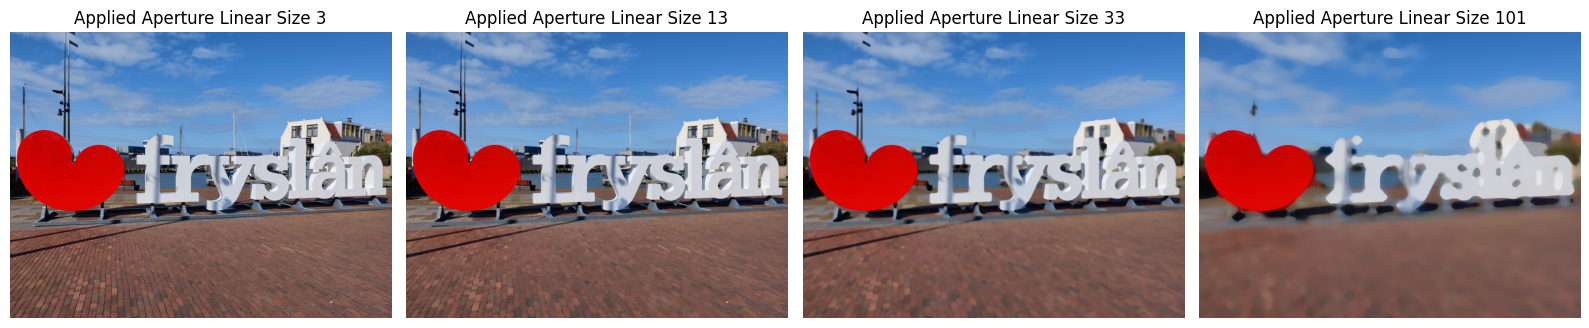

In [49]:
aperture = [3, 13, 33, 101] # aperture values must be odd and bigger than 1
fig, axs = plt.subplots(nrows=1, ncols=len(aperture), figsize=(16,8))

for idx, a in enumerate(aperture):
    res = cv.medianBlur(image, ksize=a)
    axs[idx].imshow(res, cmap='gray')
    axs[idx].axis('off')
    axs[idx].set_title(f'Applied Aperture Linear Size {a}')
plt.tight_layout()
plt.show()

## Image Borders
To be able to apply a convolution on the whole image including the borders and to return a new image with the same shape we need to treat the borders accordingly. For this there exist several methods:
* **Constant border**: Using this method all required missing border pixel are generated with a constant value. Commonly used is zero.
* **Replicate**: In this method the nearst valid pixel in the image is used outside of the image.
* **Warp**: At the borders the image the image is replicated and the missing pixels at the left borders are the same as at the right edge of the image. (Not supported in OpenCV)
* **Reflect/Mirroring**: The missing pixels are filled up with the mirrored image at this edge.

In [50]:
class BorderTypes(IntEnum):
    DEFAULT = cv.BORDER_DEFAULT # Similar to REFLECT
    CONSTANT = cv.BORDER_CONSTANT
    BORDER_REPLICATE = cv.BORDER_REPLICATE
    REFLECT = cv.BORDER_REFLECT


def apply_filter_to_image(kernel:np.array, image:np.array, amount=1, norm:bool=True, plot:bool=False, vmin=0, vmax=255, bordertype:BorderTypes=BorderTypes.DEFAULT):
    k = kernel.copy()
    if norm:
        if np.abs(np.sum(k)) > 0: 
            k /= np.sum(k)
    
    img = image
    for i in range(amount):
        img = cv.filter2D(img, ddepth=-1, kernel=k, borderType=bordertype)

    if plot:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax )
        plt.axis('off')
        plt.show()

    return img

In [51]:
tiny_image = np.ones((11,11,3))
tiny_image[0,5,1] = 0
tiny_image[0,5,2] = 0
tiny_image[1,4,2] = 0
tiny_image[1,7,1] = 0
tiny_image[1,7,0] = 0

tiny_image[5,3,0] = 0
tiny_image[5,3,1] = 0

tiny_image[10,3,1] = 0
tiny_image[10,3,2] = 0
tiny_image[10,5,0] = 0
tiny_image[10,5,2] = 0
tiny_image[10,4,1] = 0
tiny_image[10,4,2] = 0

tiny_image[3,10,2] = 0
tiny_image[4,10,1] = 0
tiny_image[5,10,0] = 0
tiny_image[5,10,1] = 0
tiny_image[4:6,9,0] = 0
tiny_image[4:6,9,2] = 0
tiny_image[6:7,10,2] = 0
tiny_image[7,10,1] = 0

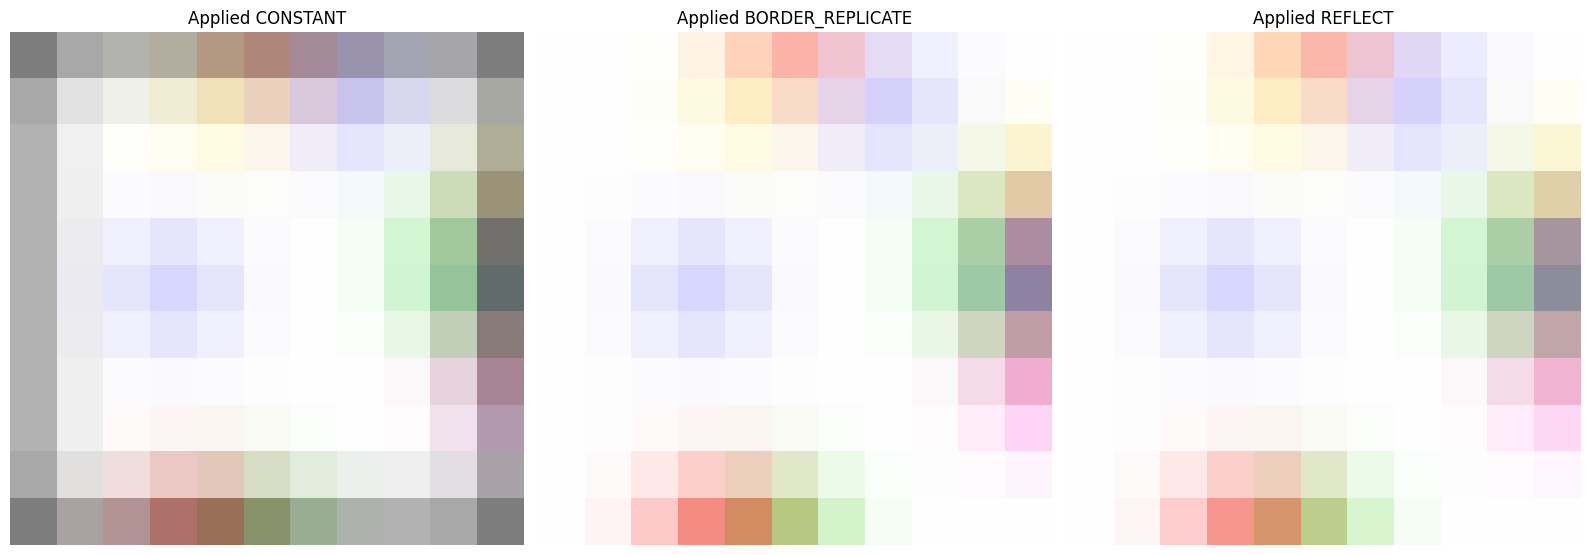

In [52]:
bordertype = [BorderTypes.CONSTANT, BorderTypes.BORDER_REPLICATE, BorderTypes.REFLECT]
fig, axs = plt.subplots(nrows=1, ncols=len(bordertype), figsize=(16,8))

for idx, bt in enumerate(bordertype):
    res = apply_filter_to_image(gauss_filter, tiny_image, amount=1, plot=False, bordertype=bt)
    axs[idx].imshow(res, cmap='gray')
    axs[idx].axis('off')
    axs[idx].set_title(f'Applied {bt.name}')
plt.tight_layout()
plt.show()


## Geometric Image Operations

There exist numerous geometric image operations such as rotation, mirroring, scaling, and many more. 
These image operations can be used to manipulate images in a certain way to for example generate similar but different samples. Such samples can for example be used to train a deep learning model (data augmentation). Such operations can be applied using matrix operations, e.g., a rotation matrix.

## Discrete Fourier Transform (DFT) on Audio

The discrete Fourier transform (DFT) algorithm is the discrete version of the Fourier transform algorithm. As we already have seen our signals are discrete and therefore the application of the DFT is the right choice.

With the help of the DFT algorithm we can transform a signal into its frequency domain. In this frequency domain the information about the frequencies of all sine waves the signal is made of is given.
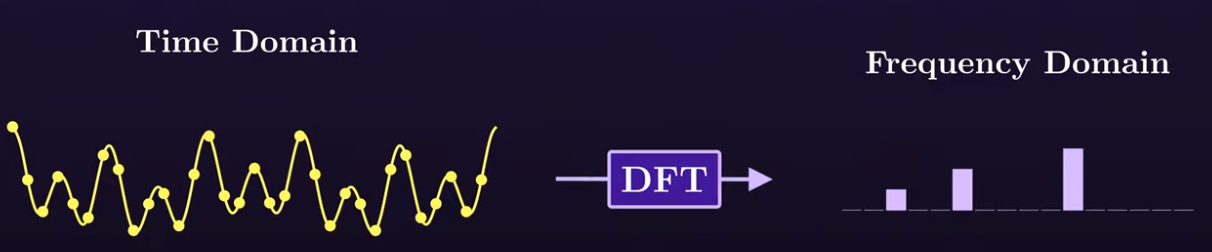
[Source](https://youtu.be/yYEMxqreA10?t=332)

**How does the DFT algorithm works?**
Simply speaking: The DFT measures the similarities between two frequencies. For this, the signal we want to transpose into its frequency domain will be compared with the dot product to many different frequencies. In the end we are interested in all frequencies where the dot product was $\neq$ 0 and are therefore in the signal.

A good visual explanation of the DFT can be watched in this [video](https://youtu.be/yYEMxqreA10?t=336).

Reference: The code used in this section is adjusted from [here](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html#dft).

In the following we first look on a music sample and see what we can do which the DFT.

### Triad
The short audio sequence we load is a triad played by a piano. We apply the ```fft``` function of numpy on this triad. 

audio=array([0.        , 0.        , 0.        , ..., 0.00346574, 0.00306236,
       0.00327726], dtype=float32)
         audio.dtype=dtype('float32')
         audio.shape=(113249,)
         np.max(audio)=0.5365303
         np.min(audio)=-0.48202172
sampling_rate=22050
len(audio)=10000


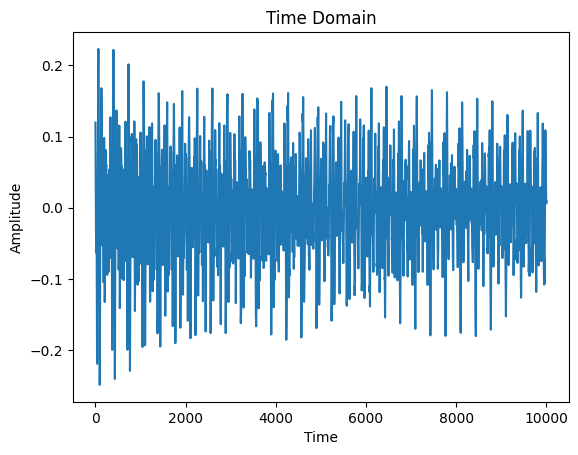

In [59]:
audio, sampling_rate = librosa.load("Sounds/Triad.mp3")
print(f"{audio=}\n \
        {audio.dtype=}\n \
        {audio.shape=}\n \
        {np.max(audio)=}\n \
        {np.min(audio)=}")
print(f"{sampling_rate=}")
audio = audio [40000:50000]
print(f"{len(audio)=}")
sd.play(audio, sampling_rate)
plt.plot(range(len(audio)), audio)
plt.title("Time Domain")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

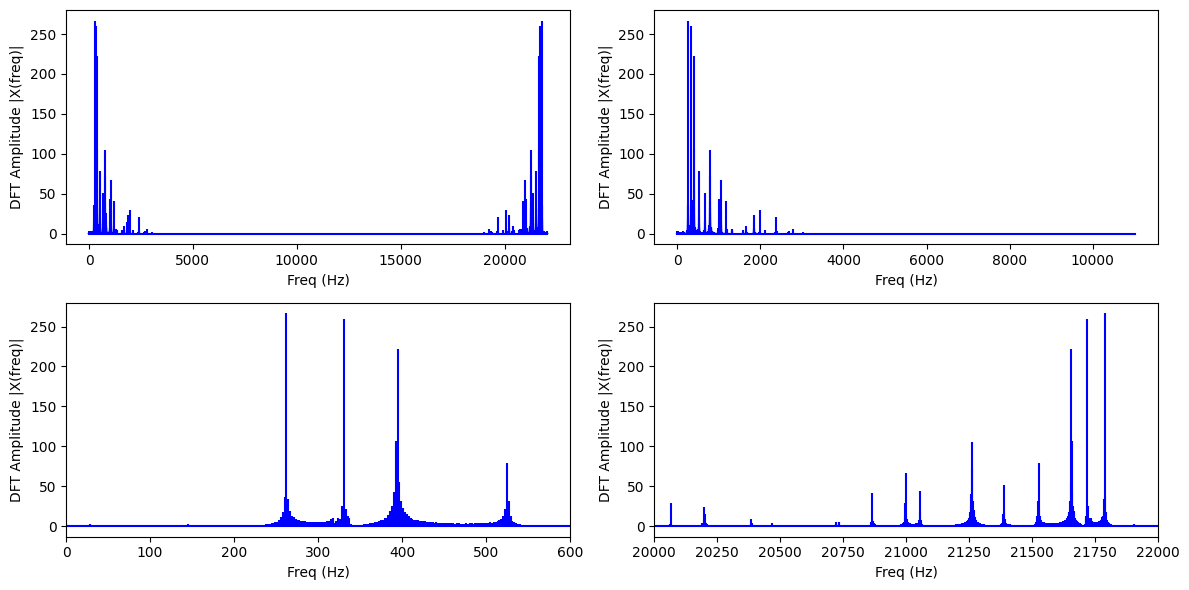

In [54]:
X = np.fft.fft(audio)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sampling_rate
freq = n/T 

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

axs[0][0].stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
axs[0][0].set_xlabel('Freq (Hz)')
axs[0][0].set_ylabel('DFT Amplitude |X(freq)|')

n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside = X[:n_oneside]

axs[0][1].stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")

axs[0][1].set_xlabel('Freq (Hz)')
axs[0][1].set_ylabel('DFT Amplitude |X(freq)|')

axs[1][0].stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")

axs[1][0].set_xlabel('Freq (Hz)')
axs[1][0].set_ylabel('DFT Amplitude |X(freq)|')
axs[1][0].set_xlim(0, 600)


axs[1][1].stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
axs[1][1].set_xlabel('Freq (Hz)')
axs[1][1].set_ylabel('DFT Amplitude |X(freq)|')
axs[1][1].set_xlim(20000, 22000)

plt.tight_layout()
plt.show()

#### <font color='blue'>Exercise:</font>
* What is visualized in these graphics? (all plots show the DFT results on different zooming levels)

Wir sehen die Frequenzen des Signals

* What tones are played together in this sound sample?

Wie sind die Auschalege zu erklaeren? 
Ueber 20k Freq kann es zu fehler kommen und die Werte sind nicht mehr korrekt.
Und links unten sind die Klaenge

#### <font color='blue'>Exercise:</font>
Why are there other frequencies that have spikes that were not played in the audio?


### Inverse DFT
Based on the frequence domain created by the DFT the signal can be reproduced by the inverse DFT function.
In the following code we apply the inverse function to our previously created frequency domain transform function and listen to the sound.

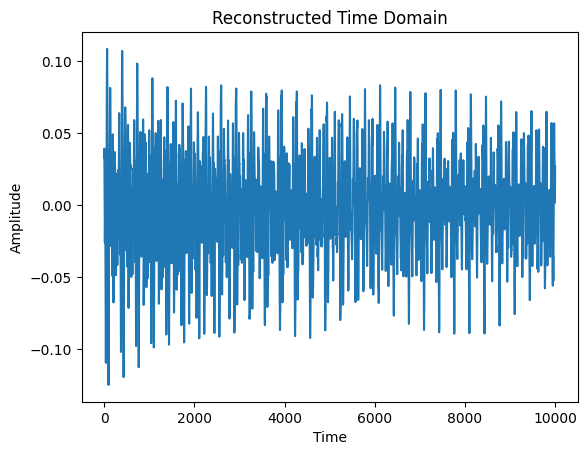

In [60]:
audio_reconstructed = np.fft.ifft(X)
sd.play(audio_reconstructed.real, sampling_rate)

plt.plot(range(len(audio)), audio_reconstructed.real)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Reconstructed Time Domain")
plt.show()

And the sound could be reconstructed! But let's measure the difference between the sound and the reconstructed sound by the peak-signal-to-noise ratio.

In [62]:
peak_signal_noise_ratio(audio, audio_reconstructed.real.astype('float32'))

34.81903228614612

This yields a very high number, it can even be infinity. This happens when the two signals are not only similar but the same.

### Remove Unwanted Frequency
The frequency domain can be used to remove unwanted frequencies out of the signal. In the following we try to remove the tone G:

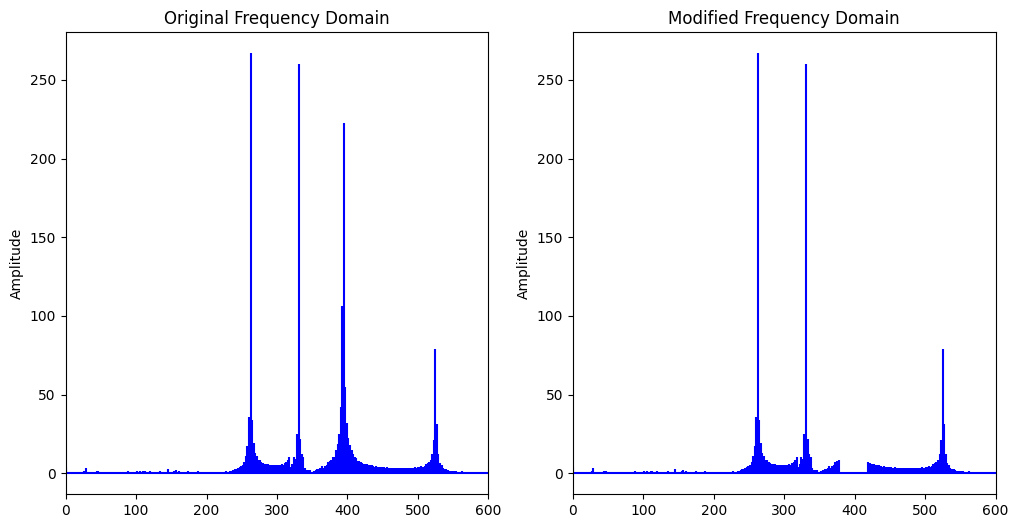

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

axs[0].stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
axs[0].set_ylabel('Amplitude')
axs[0].set_xlim(0, 600)
axs[0].set_title("Original Frequency Domain")

X_modified = X.copy()

# Remove one frquency range
X_modified[int(380*T):int(420*T)] = 0
X[int(2000*T):] = 0

axs[1].stem(freq, abs(X_modified), 'b', \
         markerfmt=" ", basefmt="-b")
axs[1].set_ylabel('Amplitude')
axs[1].set_xlim(0, 600)
axs[1].set_title("Modified Frequency Domain")

plt.show()

In [78]:
sd.play(audio, sampling_rate)

In [79]:
audio_reconstructed = np.fft.ifft(X_modified)
sd.play(audio_reconstructed.real, sampling_rate)

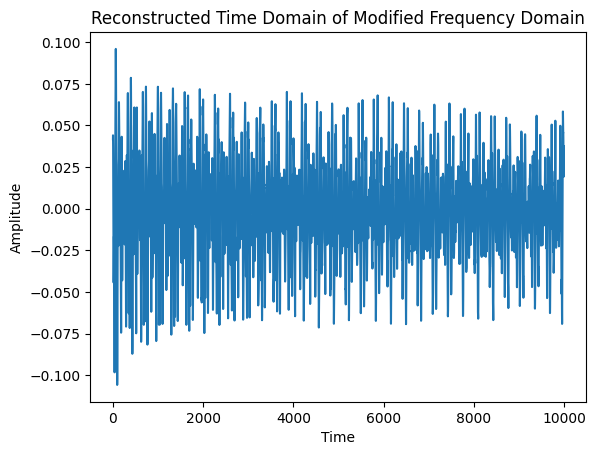

In [72]:
plt.plot(range(len(audio)), audio_reconstructed.real)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Reconstructed Time Domain of Modified Frequency Domain")
plt.show()

#### <font color='blue'>Exercise:</font>
Generate a new triad based on the DFT.

Hint: Plot the new frequency domain to prevent errors!


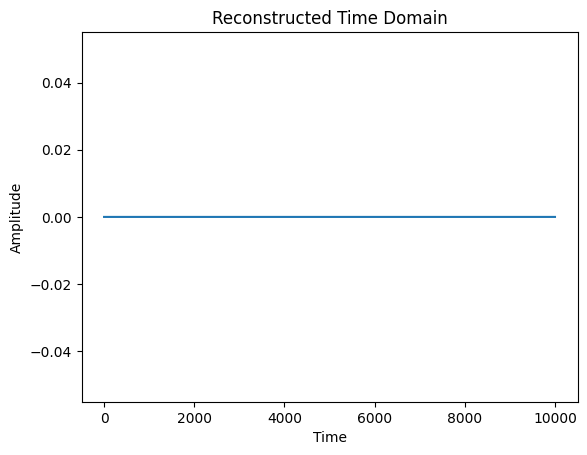

In [80]:
sampling_rate = 44100
audio_new = np.zeros(10000)

X = np.fft.fft(audio_new)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sampling_rate
freq = n/T 

# Add frequencies to the frequency domain
### BEGIN SOLUTION
...
### END SOLUTION

audio_reconstructed_new = np.fft.ifft(X)

# Plot Reconstructed Time Domain
plt.plot(range(len(audio)), audio_reconstructed_new.real)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Reconstructed Time Domain")
plt.show()

sd.play(audio_reconstructed_new.real, sampling_rate)

## Discrete Fourier Transform (DFT) on Images

The DFT can also be applied to images (2D data). For this the ```fft2``` from numpy is applied to the image to create a frequency domain. This frequency domain is as the image a 2D array.

In [81]:
def rgb_to_grayscale(image: np.ndarray, wr: int = 0.2126, wg: int = 0.7152, wb: int = 0.0722) -> np.ndarray:
    grayscale_image = image[:,:,0] * wr + image[:,:,1] * wg + image[:,:,2] * wb
    return grayscale_image

ft.dtype=dtype('complex128')
np.min(abs(ft))=2.9305210441711513
np.max(abs(ft))=1249562754.8617997


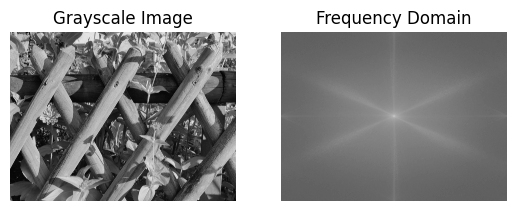

In [82]:
image = cv.imread('Images/grid.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
grayscale_image = rgb_to_grayscale(image)

ft = np.fft.ifftshift(grayscale_image)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)

print(f"{ft.dtype=}")
print(f"{np.min(abs(ft))=}")
print(f"{np.max(abs(ft))=}")

plt.set_cmap("gray")
plt.subplot(121)
plt.imshow(grayscale_image)
plt.title("Grayscale Image")
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.title("Frequency Domain")
plt.axis("off")
plt.show()

In this frequency domain the value range is very large.

#### <font color='blue'>Exercise:</font>
* In which area of the frequency domain array are the most important pixels?
* Why are rays recognizable in the frequency domain?


Now we show a few examples where we manipulated the frequency domain of the image:

In [83]:
def make_idf(original, ft, title:str = ''):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
    
    plt.set_cmap("gray")
    axs[0].imshow(original)
    axs[0].axis("off")
    
    axs[1].imshow(np.log(abs(ft)))
    axs[1].axis("off")

    ift = np.fft.ifftshift(ft)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    ift = ift.real
    mse_val = mse(original, ift)
    axs[2].imshow(ift)
    axs[2].axis("off")
    
    fig.suptitle(f"{title} - MSE: {np.round(mse_val)}", y=0.7)
    plt.tight_layout()
    plt.show()

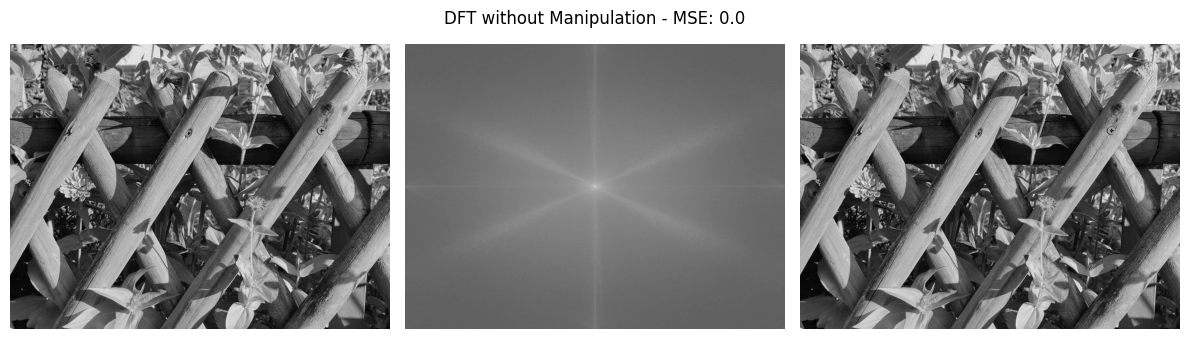

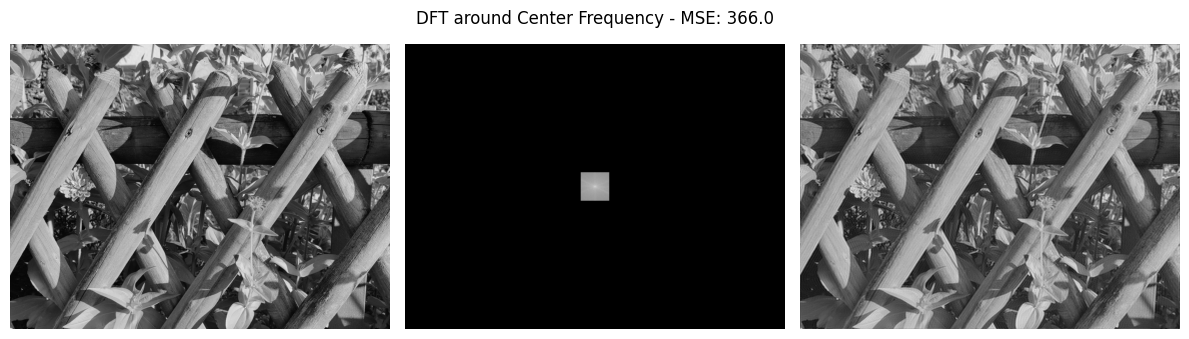

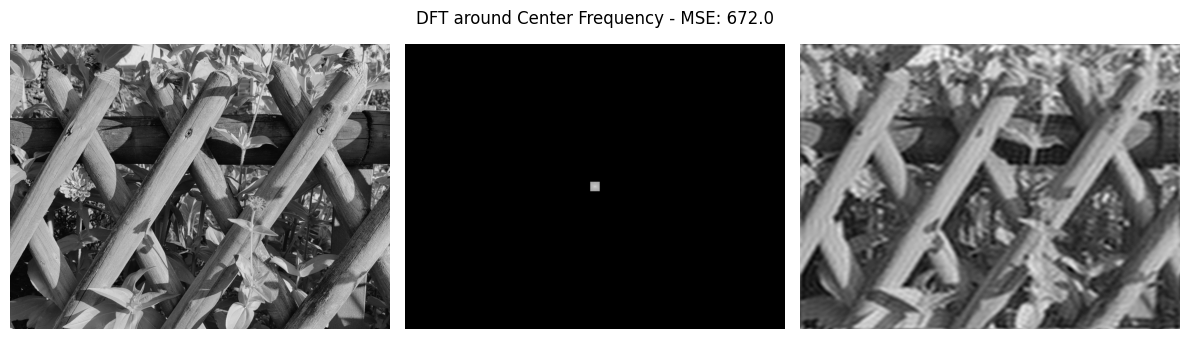

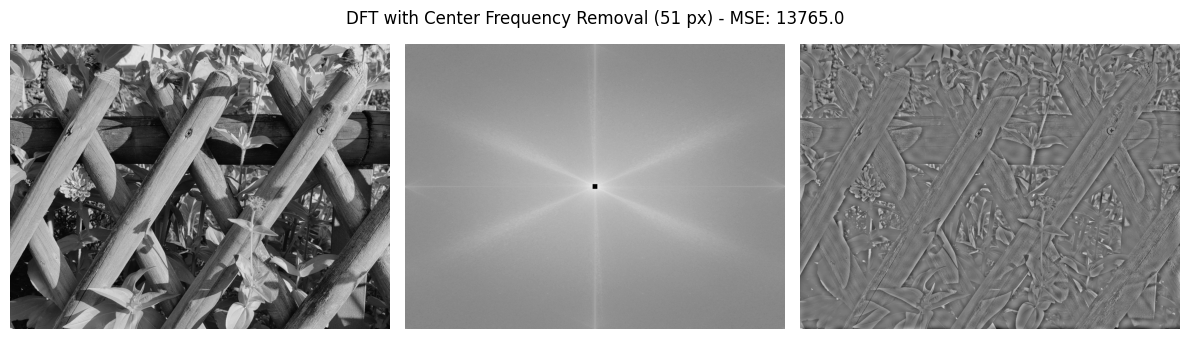

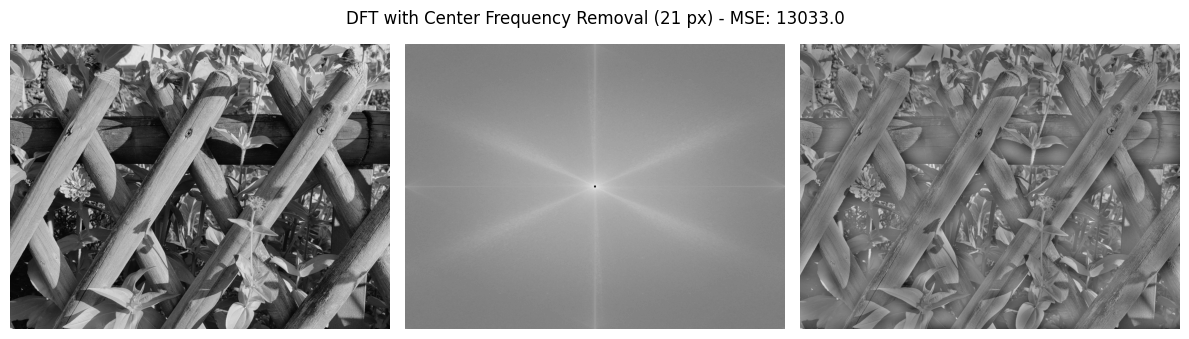

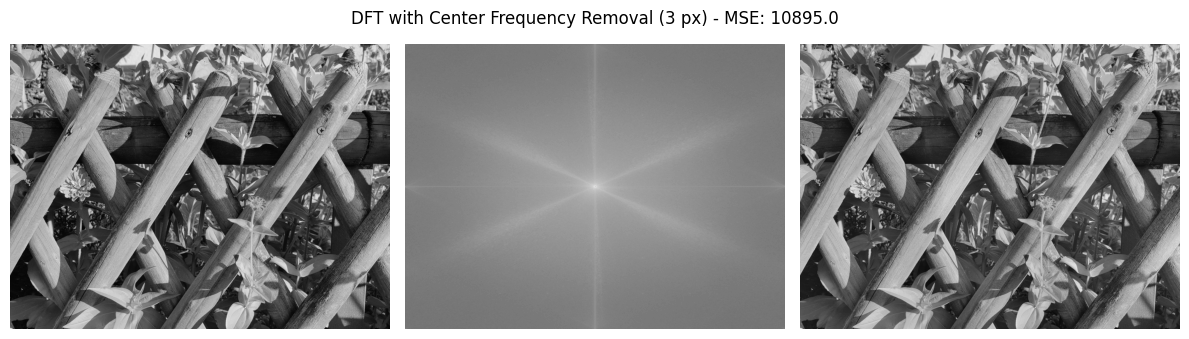

In [84]:
make_idf(grayscale_image, ft, title='DFT without Manipulation')

remove_around_ft = ft.copy()
remove_around_ft[:1350,:] = 1
remove_around_ft[1650:,:] = 1
remove_around_ft[:,:1850] = 1
remove_around_ft[:,2150:] = 1
make_idf(grayscale_image, remove_around_ft, title='DFT around Center Frequency')

remove_around_ft = ft.copy()
remove_around_ft[:1450,:] = 1
remove_around_ft[1550:,:] = 1
remove_around_ft[:,:1950] = 1
remove_around_ft[:,2050:] = 1
make_idf(grayscale_image, remove_around_ft, title='DFT around Center Frequency')

remove_center_ft = ft.copy()
remove_center_ft[1475:1525, 1975:2025] = 1
make_idf(grayscale_image, remove_center_ft, title='DFT with Center Frequency Removal (51 px)')

remove_small_center_ft = ft.copy()
remove_small_center_ft[1490:1510, 1990:2010] = 1
make_idf(grayscale_image, remove_small_center_ft, title='DFT with Center Frequency Removal (21 px)')

remove_small_center_ft = ft.copy()
remove_small_center_ft[1499:1501, 1999:2005] = 1
make_idf(grayscale_image, remove_small_center_ft, title='DFT with Center Frequency Removal (3 px)')